#                                       **CIFAR-10: Image Classification**

#   Step 1: Data Preprocessing & Loading 
##  Visualization of Images and Labels / Inserting Grayscale Conversion / Augmentation 


%pip install matplotlib
%pip install numpy
%pip install tensorflow
%pip install tensorflow-gpu

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


In [35]:
# Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [36]:
# Check data dimensions
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


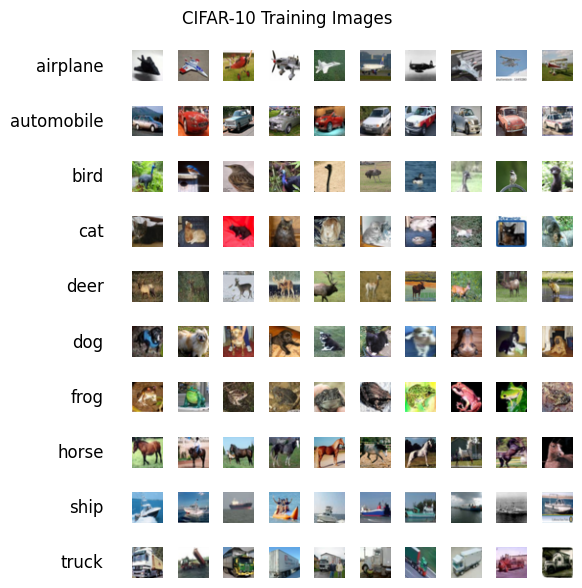

In [37]:
# Define a list with all the class labels for CIFAR-10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to visualize color images from CIFAR-10 dataset with correct labeling
def visualize_color_images_with_labels(images, labels, classes, images_per_class=10, title="CIFAR-10 Images"):
    num_classes = len(classes)
    total_images = num_classes * images_per_class

    plt.figure(figsize=(6, 6))
    image_count = 0

    # Loop through class labels to pick images_per_class images per class
    for class_index, class_name in enumerate(classes):
        class_images = images[labels.flatten() == class_index][:images_per_class]

        # Loop through the images, arranging them dynamically
        for img in class_images:
            plt.subplot(num_classes, images_per_class, image_count + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Add class label to the left side of each row
            if image_count % images_per_class == 0:
                plt.text(-30, 32 // 2, class_name, rotation=0, size='large', va='center', ha='right')
            
            image_count += 1
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize color images from the CIFAR-10 training set
visualize_color_images_with_labels(x_train, y_train, classes, images_per_class=10, title="CIFAR-10 Training Images")


In [38]:
# Data Augmentation:

# Convert images to grayscale

grayscale_x_train = tf.image.rgb_to_grayscale(x_train)
grayscale_x_test = tf.image.rgb_to_grayscale(x_test)

print(grayscale_x_train.shape)
print(grayscale_x_test.shape)

# Create augmentation layer for model (used further down)

data_augmentation = Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.RandomRotation(0.2),
]) 


(50000, 32, 32, 1)
(10000, 32, 32, 1)


In [50]:
# Normalize the images to the range [0, 1]
x_train_normalized = grayscale_x_train.astype('float32') / 255.0
x_test_normalized = grayscale_x_test.astype('float32') / 255.0

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

In [26]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"One-hot encoded label shape: {y_train.shape}")

One-hot encoded label shape: (50000, 10)


In [47]:
# Define model / data parameters
num_classes = 10
input_shape = x_train.shape[1:]
dropout_rate = 0.2
epochs = 10

# Perform the train-validation split
x_train_normalized_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_normalized, y_train, test_size=0.2, random_state=42)

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the model with data augmentation
model = Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,  # Data augmentation layer
    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(64, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')
])

# Print summary of the model
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 4096)            

In [49]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model with normalized data
history = model.fit(x_train_normalized, y_train, validation_data=(x_val_split, y_val_split), epochs=epochs, callbacks = [early_stopping])


Epoch 1/10
1563/1563 [==============================] - 68s 42ms/step - loss: 1.9452 - accuracy: 0.2723 - val_loss: 1.6999 - val_accuracy: 0.3932
Epoch 2/10
1388/1563 [=========================>....] - ETA: 4s - loss: 1.7532 - accuracy: 0.3570

KeyboardInterrupt: 

In [ ]:
# Initialize ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Compile the model with the correct loss function for integer labels
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Perform the train-validation split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    train_datagen.flow(x_train_split, y_train_split, batch_size=64),
    validation_data=(x_val_split, y_val_split),
    epochs=10
)

# Check the accuracy and loss values after the first epoch
initial_train_acc = history.history['accuracy'][0]
initial_val_acc = history.history['val_accuracy'][0]

assert initial_train_acc > 0, "Model training didn't start properly!"
assert initial_val_acc > 0, "Validation accuracy not improving!"


In [20]:
# Function to collect augmented data
def collect_augmented_data(datagen, x_data, y_data, batch_size=32):
    iterator = datagen.flow(x_data, y_data, batch_size=batch_size)
    augmented_images = []
    augmented_labels = []
    
    total_samples = len(x_data)
    batches_to_process = int(np.ceil(total_samples / batch_size))
    
    #TODO
    # you are missing the data augmentation part here 
    for _ in range(batches_to_process):
        augmented_batch, labels_batch = next(iterator)
        augmented_images.append(augmented_batch)
        augmented_labels.append(labels_batch)


    # TODO 
    #to be check, might be better to keep in batches too 
    augmented_images = np.concatenate(augmented_images)
    augmented_labels = np.concatenate(augmented_labels)
    

    # sanity check 
    # Ensure images have a single channel by reshaping if necessary
    if augmented_images.shape[-1] == 3:  # If still in 32x32x3 shape
        augmented_images = np.mean(augmented_images, axis=-1, keepdims=True)

    return augmented_images, augmented_labels

# Collect augmented training data
augmented_x_train, augmented_y_train = collect_augmented_data(datagen, x_train, y_train)
# Collect augmented testing data
augmented_x_test, augmented_y_test = collect_augmented_data(datagen, x_test, y_test)

# Check data dimensions after augmentationprint("Augmented Training Images Shape:", augmented_x_train.shape)
print("Augmented Training Labels Shape:", augmented_y_train.shape)
print("Augmented Testing Images Shape:", augmented_x_test.shape)
print("Augmented Testing Labels Shape:", augmented_y_test.shape)


NameError: name 'datagen' is not defined

# This block Bellow works dont edit!

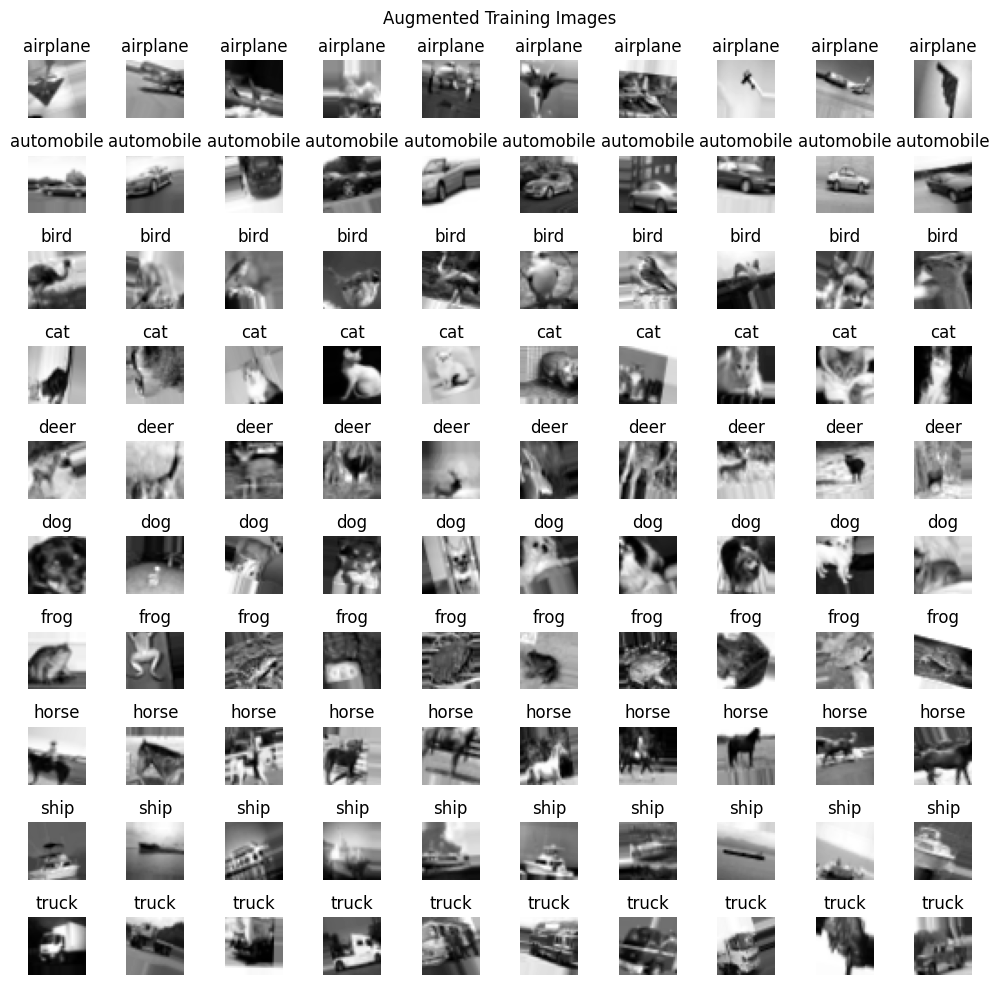

In [7]:
# Function to visualize augmented images
def visualize_augmented_images(images, labels, classes, title="Augmented Images", images_per_class=10):
    num_classes = len(classes)
    total_images = num_classes * images_per_class

    plt.figure(figsize=(10, 10))
    image_count = 0

    # Loop through class labels to pick images_per_class images per class
    for class_index, class_name in enumerate(classes):
        class_images = images[labels.flatten() == class_index][:images_per_class]
        
        # Loop through the images, arranging them dynamically
        for img in class_images:
            plt.subplot(num_classes, images_per_class, image_count + 1)
            if img.shape[-1] == 1:  # Handle grayscale images
                plt.imshow(img.squeeze(), cmap='gray')  # Simplified grayscale handling
            else:
                plt.imshow(img)

            plt.axis('off')
            plt.title(class_name)
            image_count += 1
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show augmented images from training set
visualize_augmented_images(augmented_x_train, augmented_y_train, classes, title="Augmented Training Images")


In [1]:
# One hot encoding labels to categorical
augmented_y_train = to_categorical(augmented_y_train, num_classes=10)
augmented_y_test = to_categorical(augmented_y_test, num_classes=10)

print(augmented_y_train.shape)
print(augmented_y_test.shape)

NameError: name 'to_categorical' is not defined

In [28]:
# Split the augemented training data into training and validation sets
#x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(augmented_x_train, augmented_y_train, test_size=0.2, random_state=42)

# Check the shapes of the new training and validation sets
#print(f'Training set size: {x_train_split.shape}')
#print(f'Validation set size: {x_val_split.shape}')

In [29]:
# Rename augmented variables to avoid confusion
x_test = augmented_x_test
y_test = augmented_y_test
x_train = augmented_x_train
y_train = augmented_y_train

# Check the shapes of the test and training set
print(f'Test set size: {x_test.shape}, {y_test.shape}')
print(f'Training set size: {x_train.shape}, {y_train.shape}')

Test set size: (10000, 32, 32, 1), (10000, 10)
Training set size: (50000, 32, 32, 1), (50000, 10)


#   Step 2: Model Architecture
## Designing the CNN Architecture

In [30]:
# Define model / data parameters
num_classes = 10
input_shape = x_train.shape[1:]
dropout_rate = 0.2

model = Sequential([

    data_augmentation, # Adding data augmentation to model
    
    Conv2D(32, (3, 3), activation='relu', input_shape = input_shape), # One set of Convolutional and Max Pooling layers
    MaxPooling2D((2, 2)),

    Flatten(), # Flattening layer

    Dense(50, activation='relu'), # Add Dense layer 

    Dropout(dropout_rate), # Add Dropout layer for better regularization
    Dense(64, activation='relu'), # Add another Dense layer

    
    Dropout(dropout_rate),  # Add Dropout layer for better regularization
    
    Dense(num_classes, activation='softmax') # Output layer
])

# Try different learning rate / optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_3 (Dense)             (None, 50)                360050    
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                3264      
                                                      

# Step 3: Model Training
## Training the CNN Model

In [31]:
# Train the model
#history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test,y_test))

In [32]:
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [34]:
x_train.shape

(50000, 32, 32, 1)

In [35]:
y_train.shape

(50000, 10)

In [33]:
model.fit(x_train, y_train)

#print(history.history)


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\diego\AppData\Local\Temp\ipykernel_34604\370564187.py", line 1, in <module>
      model.fit(x_train, y_train)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\diego\anaconda3\envs\tensorflow_env\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1801667]

In [37]:
history = model.fit(train_datagen.flow(x_train_split, y_train_split, batch_size=64),
                    validation_data=(x_val_split, y_val_split),
                    epochs=10)

# Check the accuracy and loss values after the first epoch
initial_train_acc = history.history['accuracy'][0]
initial_val_acc = history.history['val_accuracy'][0]
assert initial_train_acc > 0, "Model training didn't start properly!"
assert initial_val_acc > 0, "Validation accuracy not improving!"


NameError: name 'train_datagen' is not defined

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Check for overfitting if training accuracy is significantly higher than validation accuracy
assert final_train_acc - final_val_acc < 0.1, "Model might be overfitting!"

#  Step 4: Model Evaluation
## Evaluate the Model and Compute Metrics

In [ ]:
# Print training accuracy and loss curves
print(history.history.keys())

print(history.history['loss']) # returns the loss value at the end of each epoch
print(history.history['accuracy']) # returns the accuracy at the end of each epoch

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.show()

In [ ]:
# Make prediction
predictions = model.predict(x_test)

predictions = np.argmax(predictions, axis=1)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix

gt = np.argmax(y_test, axis=1)
confusion_matrix(gt, predictions)

In [ ]:
# Print test accuracy and test loss for trained model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)